# <center>High-Resolution Wetland Indentifcation through Machine Learning </center>

## <center>Applications to Forested Wetlands in the Hiawatha National Forest</center>

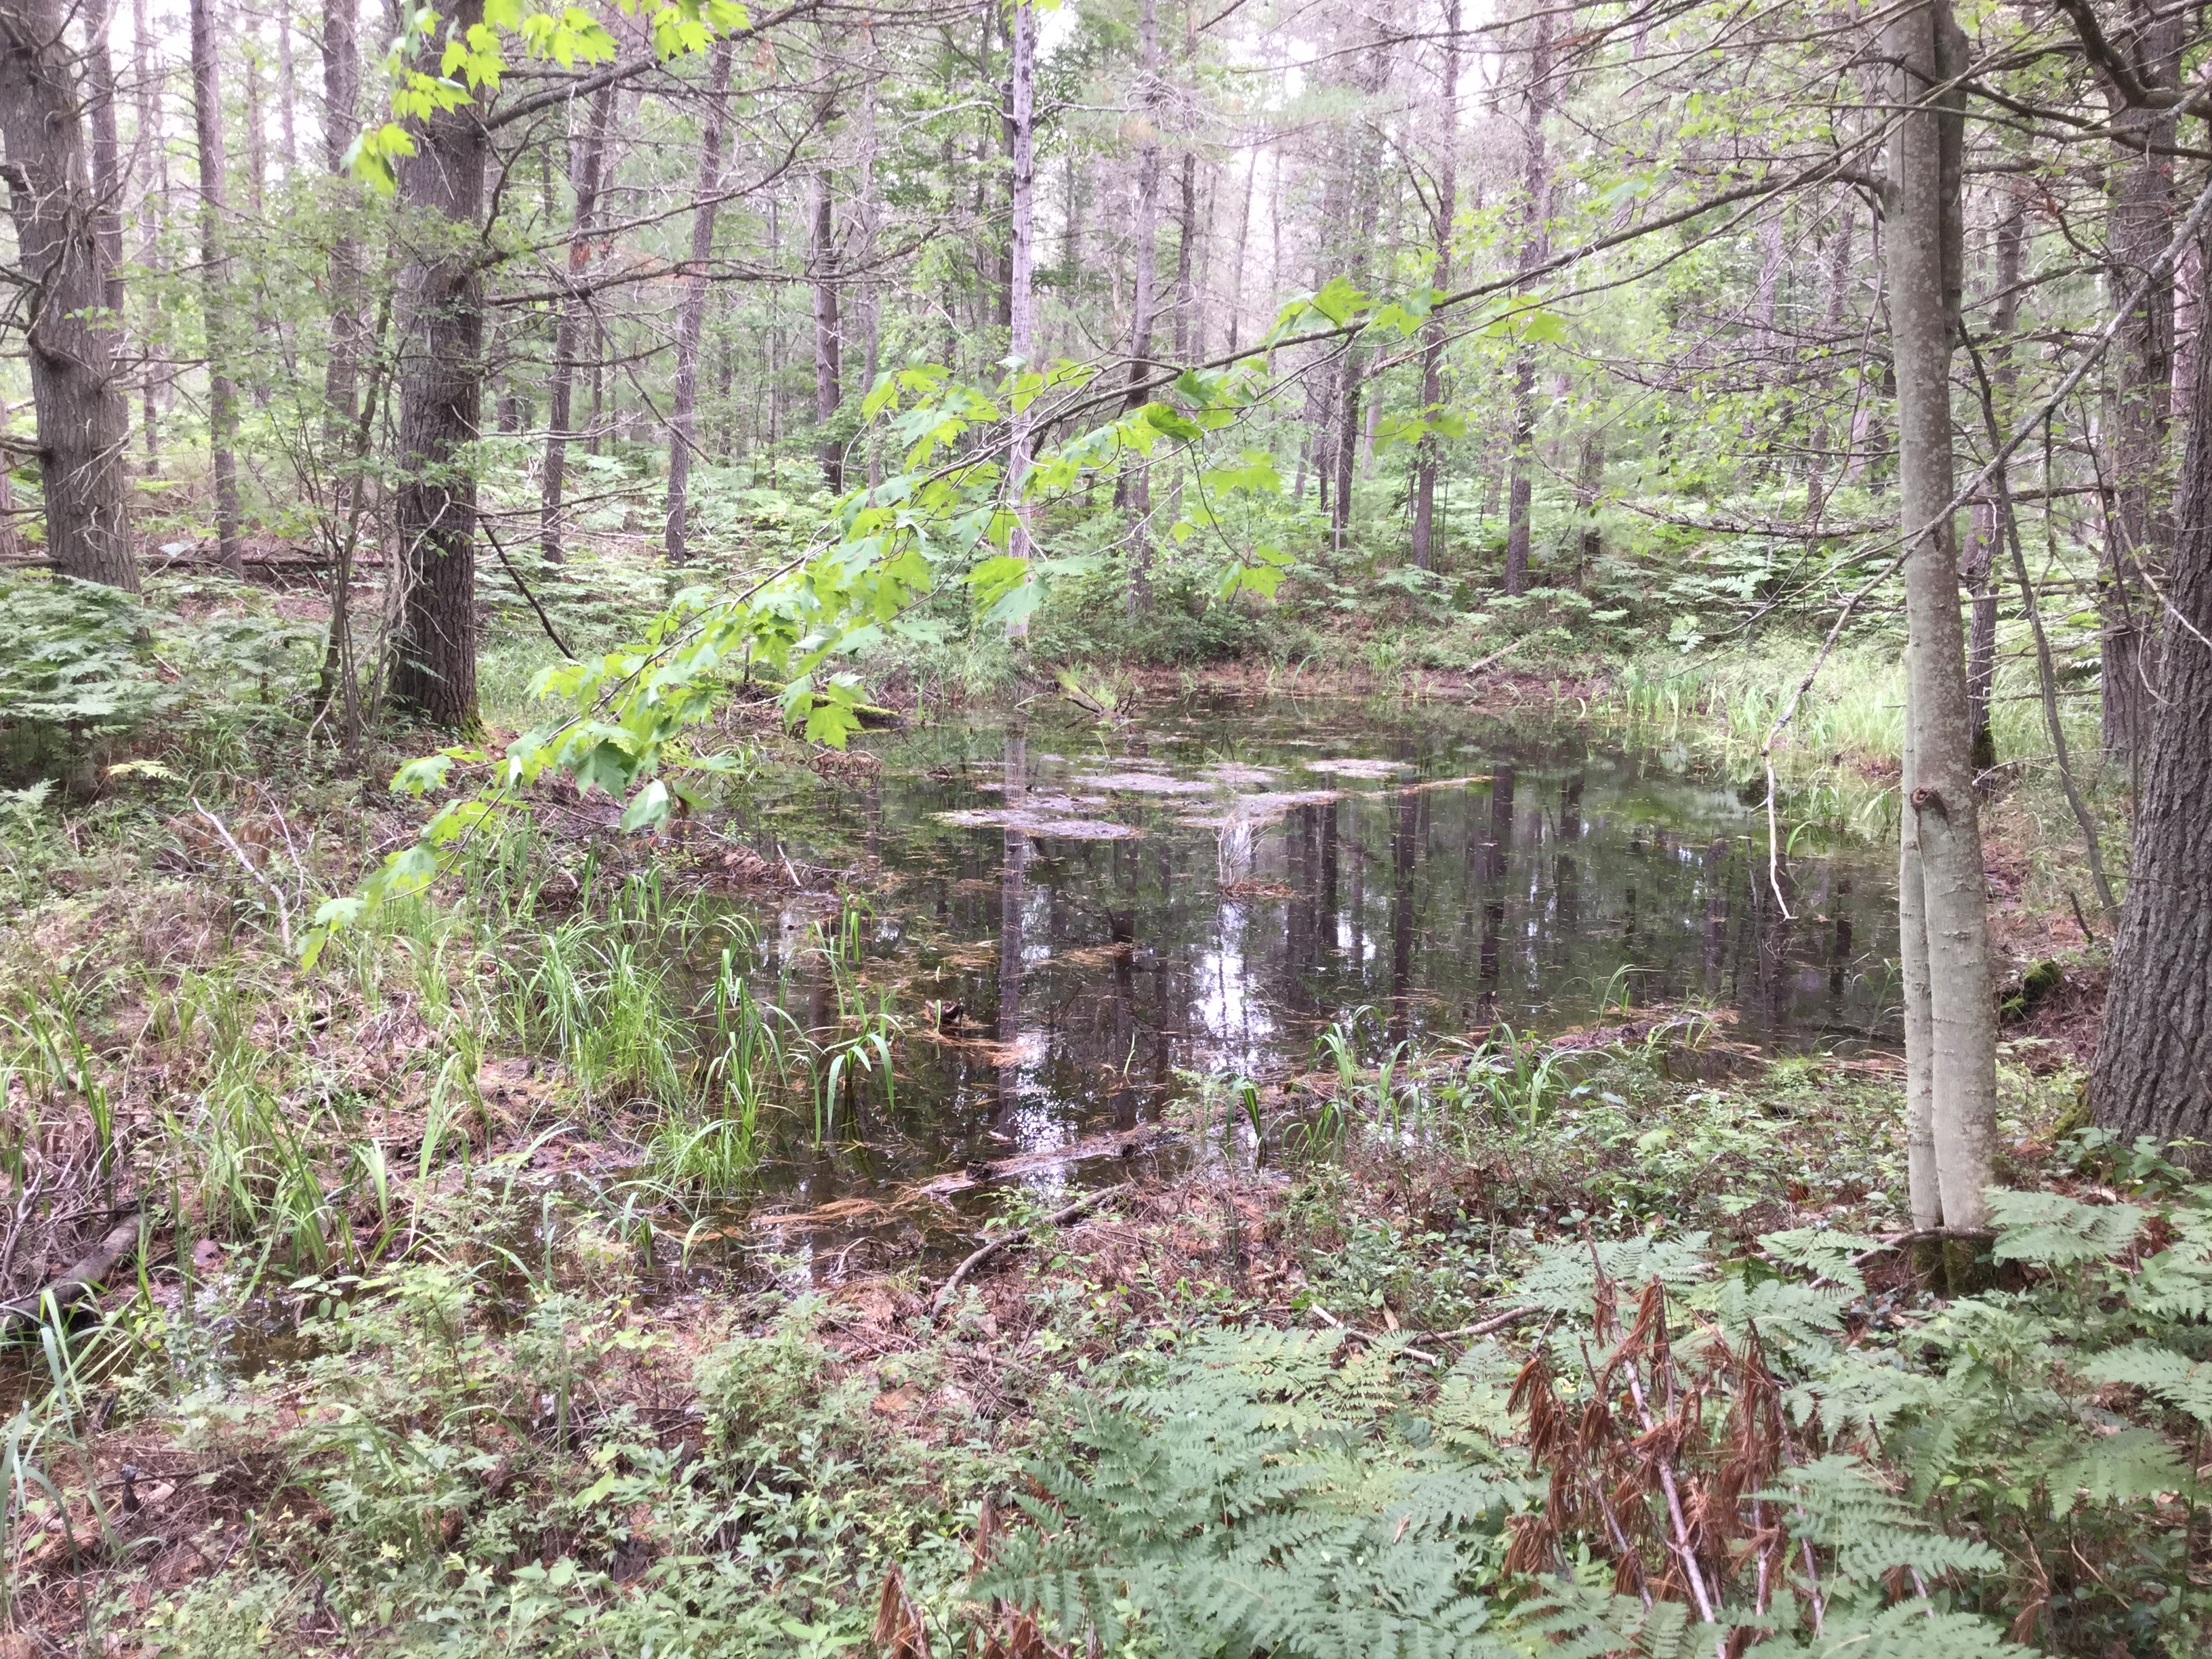

<center> A small, ephermeral wetland in a Lake Michigan shoreline 'dune and swale' complex in the Hiawatha National Forest </center> 

## Why do we need good wetland maps?

Accurate, high-resolution wetlands maps make it easier for interdisciplinary land management teams to communicate about wetland conservation, and therefore better enact sustainable land managment plans. 

In U.S. national forests like the Hiawatha, as well as on other public and privately-owned forested properties, the land is managed for human uses including recreation and timber harvesting. However, forests are generally healthier (and therefore harvests and recreating are better!) if these areas are sustainably management to support natural ecosystems, like wetlands. 

**But what are wetlands and why is it important to minimize our impacton them?**

According to the [EPA](https://www.epa.gov/wetlands/what-wetland),**wetlands are areas where water covers the soil, or is present either at or near the surface of the soil all year or for varying periods of time during the year.** Wetlands are important environments for many reasons. Two often-sited reasons are that they support high concentrations of animals and serve as nurseries for many species and that they provide a range of [ecosystem services](https://www.nwf.org/Educational-Resources/Wildlife-Guide/Understanding-Conservation/Ecosystem-Services) that benefit humanity, including water filtration, storm protection, flood control and recreation ([World Wildlife Fund](https://www.worldwildlife.org/habitats/wetlands)). If wetlands are disturbed, filled in, or otherwise destroyed they can no longer serve these functions. The effects of such distrubances also have a global impact, since wetlands are important to the global migration of animals, [such as birds](https://www.allaboutbirds.org/news/the-tide-is-turning-for-shorebirds-of-chinas-yellow-sea/) and act as sinks for atmospheric carbon ([Nahlik and Fennessy, 2016](https://www.nature.com/articles/ncomms13835)).

**Wetlands are fragile** and susceptible to human alteration. Because it is difficult to build or farm on wetlands, they have often been treated as an inconvience by people, which has lead to the alteration of many wetlands by people. Other human impacts on wetlands are wholly inadvertant. Some examples of human impacts on wetlands include alterations to flow regime, changes in weater chemistry, habitat alterations, and the introduction of new species ([Queensland Department of Agriculture and Fisheries](https://www.daf.qld.gov.au/business-priorities/fisheries/habitats/human-impacts-wetlands)). Specifically in Michigan, ~40% of wetlands have been destroyed since the early 1800's ([FLOW](https://forloveofwater.org/issues/wetlands-destruction/)). 

Simply put, <center>**better maps = better land managment = healthier wetlands = healthier forests**</center>


## Why do you want to make "better" maps? What's wrong with the maps currently being used?

Some wetlands map are not very high resolution - which allows for wetlands smaller than ~60 m (200 feet) in diameter to be left off maps.

Like any type of map, the maps of wetlands used for land management purposes in the U.S. vary in quality, accuracy, and amount of detail provided. This variety usually depends on either the original purpose of the map - which would determine its extent and scale (resolution) - and the type of data that were availible when the map was made.

When I worked at the Hiawatha, the map of wetlands used during forest planning was the U.S. Fish and Wildlife Service's [National Wetlands Inventory (NWI)](https://www.fws.gov/wetlands/nwi/Overview.html). This is an excellent, national, polygon-based dataset that provides detailed information on the abundance, characteristics, and distribution of U.S. wetlands. NWI data can be accessed through the [Wetlands Mapper](https://www.fws.gov/wetlands/data/Mapper.html) tool. The completeness and accuracy of the NWI varies by region ([Chignell et al., 2018](https://zslpublications.onlinelibrary.wiley.com/doi/pdfdirect/10.1002/rse2.63)).

While the NWI dataset was originally created in the 1970's and 1980's using high-altitude (1:130,000, 1:80,000, and 1:62,500 scale) photographs; 1 mm on these images would equal 120 m, 80 m, and 62.5 m respectively. While this original mapping was a monumental and important effort, this ~120 - 62 m spatial resolution did not always allow for mappers to capture smaller-scale wetlands. These wetlands datasets tend towards, errors of omission rather than commission, particularly in remote and forested areas, like the Hiawatha NF ([Chignell et al., 2018](https://zslpublications.onlinelibrary.wiley.com/doi/pdfdirect/10.1002/rse2.63)).

Fortunately, the NWI database is constantly being updated, using increasingly detailed dataset, with new versions released in May and October of every year!

Unfortunately, which areas of the U.S. are updated is a piecemeal effort, generally based on local or state funding initiatives. Many of these area aren't updated more frequently because that process is time-intensive, requires expert skill and knowledge, and is therefore expensive. 

## Proposed Solution

The purpose of this project is to try to accelerate the high-resolution (1 m- scale) classification of wetlands using machine learning with remotely sensed datasets.

## Study Area: Hiawatha National Forest

The Hiawatha National Forest is located in the eastern Upper Peninsula of Michigan, USA (see map below). The Hiawatha is devided into two "zones" - the East Zone and West Zone. Some watersheds within the Hiawatha NF have updated, 1m-resolution NWI datasets (like the Brevort-Millequonquins watershed - see map), while others do not (like the Carp River watershed).

The goal of this study is to make a 1m classified wetlands raster of the Carp River Watershed, based on machine learning in adjacent watershed.

In [1]:
{
    "tags": [
        "hide_input",
    ]
}

import os
from glob import glob

import matplotlib.pyplot as plt
import earthpy as et
import geopandas as gpd
import shapely

import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Set working directory to 'HOME/earth-analytics/data'
earth_analytics_path = os.path.join(
    et.io.HOME, "earth-analytics", "data")

os.chdir(earth_analytics_path)

# print ('Your working directory is', earth_analytics_path)

# Importing Carp River Watershed Shape from USGS Watershed Boundary Dataset
# Download from the National Map Webservice
wbd_url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_04_HU2_Shape.zip'
wbd_data = et.data.get_data(url=wbd_url)
wbd_path = os.path.join(wbd_data)

wbd_path_HU10 = os.path.commonpath(glob(os.path.join(wbd_path,"*","*HU10*.shp")))
wbd_path_HU10

# Open Shapefile
wbd_HU10_boundaries = gpd.read_file(wbd_path_HU10)
# Select and plot watershed boundary
# Carp River = 'HUC10-0420000101'
target_hu10_code = '0420000101'
carp_river_hu10_boundary = wbd_HU10_boundaries.loc[wbd_HU10_boundaries['huc10']
                                                   == target_hu10_code]

# Importing National Wetlands Inventory (NWI) shapefiles for target watershed
# Smallest way to download is by HUC8 Watershed
# Carp-Pine Watershed = HUC 04070002
target_huc12_cod = '04070002'
nwi_url = 'https://www.fws.gov/wetlands/downloads/Watershed/HU8_04070002_watershed.zip'
nwi_data = et.data.get_data(url=nwi_url)
nwi_path = os.path.join(nwi_data)

nwi_path_HU8 = (glob(os.path.join(nwi_path,"*","*Wetlands.*shp")))
nwi_path_HU8 = os.path.commonpath(nwi_path_HU8)

# Open Shapefile
nwi_wetland_areas = gpd.read_file(nwi_path_HU8,
                                 mask=carp_river_hu10_boundary)

nwi_wetland_areas = nwi_wetland_areas[nwi_wetland_areas.WETLAND_TY != 'Lake']
nwi_wetland_areas_target = nwi_wetland_areas[nwi_wetland_areas.WETLAND_TY != 'Riverine']

# Reproject Watershed Boundary
nwi_wetland_areas_target = nwi_wetland_areas_target.to_crs(
    carp_river_hu10_boundary.crs)


# Importing National Wetlands Inventory (NWI) shapefiles for TRAINING watershed

target_huc12_cod = '04060107'
nwi_url = 'https://www.fws.gov/wetlands/downloads/Watershed/HU8_04060107_watershed.zip'
nwi_data = et.data.get_data(url=nwi_url)
nwi_path = os.path.join(nwi_data)

nwi_path_HU8 = (glob(os.path.join(nwi_path,"*","*Wetlands.*shp")))
nwi_path_HU8 = os.path.commonpath(nwi_path_HU8)

#HU8 Watershed Boundary
HU8_boundary_path = os.path.commonpath(glob(os.path.join(nwi_path,"*","*Watershed.*shp")))
HU8_boundary = gpd.read_file(HU8_boundary_path)

# Open Shapefile
nwi_wetland_areas_all = gpd.read_file(nwi_path_HU8)

nwi_wetland_areas = nwi_wetland_areas_all[nwi_wetland_areas_all.WETLAND_TY != 'Lake']
nwi_wetland_areas_training = nwi_wetland_areas[nwi_wetland_areas.WETLAND_TY != 'Riverine']


# Import Forest Boundaries
cwd = os.getcwd()
Hia_NF_path = os.path.join(
    cwd,"hiawatha_NF_borders.shp")
Hia_NF_boundary = gpd.read_file(Hia_NF_path)


# Folium Map

# Polygons to geographic coordinates
nwi_wetland_areas_training_geo = nwi_wetland_areas_training.to_crs(
    carp_river_hu10_boundary.crs)

nwi_wetland_areas_target_geo = nwi_wetland_areas_target.to_crs(
    carp_river_hu10_boundary.crs)

HU8_boundary_proj_geo = HU8_boundary.to_crs(
    carp_river_hu10_boundary.crs)

carp_river_hu10_boundary_geo = carp_river_hu10_boundary.to_crs(
    carp_river_hu10_boundary.crs)

Hia_NF_boundary_geo = Hia_NF_boundary.to_crs(
    carp_river_hu10_boundary.crs)

# Define Map Center
map_center_x = (
    Hia_NF_boundary_geo.total_bounds[0] + Hia_NF_boundary_geo.total_bounds[2])/2
map_center_y = (
    Hia_NF_boundary_geo.total_bounds[1] + Hia_NF_boundary_geo.total_bounds[3])/2

# Set basemap and zoom
m = folium.Map(location=[map_center_y, map_center_x],
               zoom_start=8,
               tiles='cartodbpositron')


# adapted from example at https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html


style1 = lambda x: {'fillColor': '#8c510a',
                       'stroke': True,
                       'weight': .1,
                       'color': 'black'}


style2 = lambda x: {'fillColor': '#01665e',
                       'stroke': True,
                       'weight': .1,
                       'color': 'black'}

style3 = lambda x: {'fill': False,
                       'stroke': True,
                       'weight': 2,
                       'color': 'black'}

hia_geo = gpd.GeoSeries(Hia_NF_boundary_geo['geometry'])
geo_j_3 = hia_geo.to_json()
geo_j_3 = folium.GeoJson(data=geo_j_3,
                           style_function=style3)
geo_j_3.add_to(m)

bre_mil_geo = gpd.GeoSeries(HU8_boundary_proj_geo['geometry'])
geo_j_1 = bre_mil_geo.to_json()
geo_j_1 = folium.GeoJson(data=geo_j_1,
                           style_function=style1)
geo_j_1.add_to(m)

carp_geo = gpd.GeoSeries(carp_river_hu10_boundary_geo['geometry'])
geo_j_2 = carp_geo.to_json()
geo_j_2 = folium.GeoJson(data=geo_j_2,
                           style_function=style2)
geo_j_2.add_to(m)



# for index, row in nwi_wetland_areas_training_geo.iterrows():
#     sim_geo = gpd.GeoSeries(row['geometry'])
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=style1)
#     folium.Popup(row['WETLAND_TY']).add_to(geo_j)
#     geo_j.add_to(m)

# for index, row in nwi_wetland_areas_target_geo.iterrows():
#     sim_geo = gpd.GeoSeries(row['geometry'])
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=style2)
#     folium.Popup(row['WETLAND_TY']).add_to(geo_j)
#     geo_j.add_to(m)
m

C:\Users\libby\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<center> Map of the Hiawatha National Forest and the watersheds proposed to be used in this study. The thick black outlines indicate the boundaries of the Hiawatha National Forest. The blue area shows the Carp River Watershed, and the darker blue areas are the NWI wetland polygons within that watershed. The orange areas shows the Brevort-Millequonquins Watershed, and the darker orange areas are the NWI polygons for that watershed. You can zoom in and click on all the polygons to see what their wetland type is!</center>

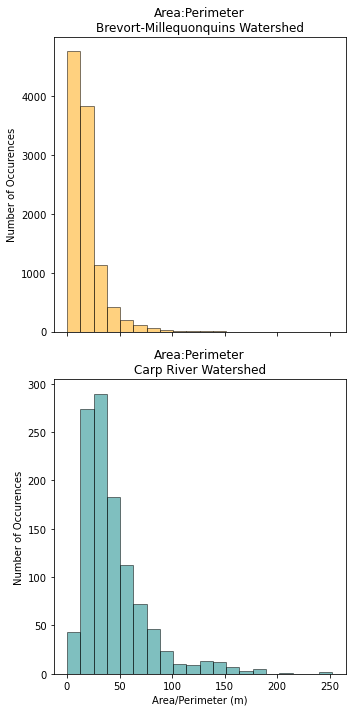

In [2]:
{
    "tags": [
        "hide_input",
    ]
}
# Reproject to projected CRS: NAD83(CSRS) / UTM zone 16N
HU8_boundary_proj = HU8_boundary.to_crs(epsg=3160)
nwi_wetland_areas_training_proj = nwi_wetland_areas_training.to_crs(epsg=3160)
nwi_wetland_areas_target_proj = nwi_wetland_areas_target.to_crs(epsg=3160)
carp_river_hu10_boundary_proj = carp_river_hu10_boundary.to_crs(epsg=3160)
nwi_wetland_areas_all = nwi_wetland_areas_all.to_crs(epsg=3160)

# Area/Perimeter Length Calculations
nwi_wetland_areas_training_proj['A/P'] = (nwi_wetland_areas_training_proj['Shape_Area'] /
                                          nwi_wetland_areas_training_proj['Shape_Leng'])
nwi_wetland_areas_target['A/P'] = (nwi_wetland_areas_target['Shape_Area'] /
                                   nwi_wetland_areas_target['Shape_Leng'])

#A/P Summary Statistics
bre_mil_wetland_ap_stats = nwi_wetland_areas_training_proj['A/P'].describe()
carp_wetland_ap_stats = nwi_wetland_areas_target['A/P'].describe()

# Area Summary Statistics
bre_mil_wetland_area_stats = nwi_wetland_areas_training_proj['Shape_Area'].describe()
carp_wetland_area_stats = nwi_wetland_areas_target['Shape_Area'].describe()

# Area/ Perimeter Histogram
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(5,10), sharex = True)

n_bins = 20

# Plot Area Historgrams
# axs[0].hist((nwi_wetland_areas_training_proj['Shape_Area']),
#             bins=n_bins,
#             range=[0, carp_wetland_area_stats[6]],
#             alpha=0.5,
#             edgecolor='black',
#             color='teal',
#             label='Brevort-Milleconquin [Training]')

# axs[1].hist((nwi_wetland_areas_target['Shape_Area']),
#             bins=n_bins,
#             range=[0, carp_wetland_area_stats[6]],
#             alpha=0.5,
#             edgecolor='black',
#             color='grey',
#             label='Carp River [Target]')

axs[0].hist((nwi_wetland_areas_training_proj['A/P']),
            bins=n_bins,
            range=[0, carp_wetland_ap_stats[7]],
            alpha=0.5,
            edgecolor='black',
            color='orange',
            label='Brevort-Milleconquin [Training]')
axs[0].set_title('Area:Perimeter\nBrevort-Millequonquins Watershed')
# axs[0].set_xlabel('Area/Perimeter (m)')
axs[0].set_ylabel('Number of Occurences')

axs[1].hist((nwi_wetland_areas_target['A/P']),
            bins=n_bins,
            range=[0, carp_wetland_ap_stats[7]],
            alpha=0.5,
            edgecolor='black',
            color='teal',
            label='Carp River [Target]')
axs[1].set_title('Area:Perimeter\nCarp River Watershed')
axs[1].set_xlabel('Area/Perimeter (m)')
axs[1].set_ylabel('Number of Occurences')

plt.show()

<center> These histograms show frequency of (Area/Perimeter) values for NWI polygons in the Brevort-Millequonquins and Carp River watersheds. The smaller the (Area/Perimeter) value, the more complex the polygon shape is. This simple parameter demonstrates that the older NWI data of the Carp River Watershed is less detailed than the more recently mapped data of the Brevort-Millequonquins. </center>

## Work Flow

![wetland-classification-flow-chart.png](wetland-classification-flow-chart.png)

<center> Proposed project work flow. Boxes are color-coded as follows: Green = Done/Almost Done, Red = Might get to this semester, Grey = Probably won't get to. </center> 

## Data Types and Sources

### Likely model input datatypes:

- **[NWI Shapefiles](https://www.fws.gov/wetlands/data/Mapper.html)**
    - In the NWI *Wetlands Mapper* tool, there is a "get data by watershed function". This will give you a URL that allow you to download NWI shapefiles.
    - **Source:** NWI *Wetlands Mapper*
    
    
- **Watershed Boundaries**
    - Watershed boundaries for HU8 watersheds can be downloaded with NWI data as described above, but if you need a smaller or larger watershed boundary...
    - These can be downloaded from the *USGS Watershed Boundaries* dataset which is part of the *National Hydrography Dataset*, which is availible through the [USGS National Map](https://apps.nationalmap.gov/downloader/#/).
    - **Source:** USGS National Map Enterprise Service


- **[NAIP Imagery](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/).** 
    - "NAIP imagery is acquired at a one-meter ground sample distance (GSD) with a horizontal accuracy that matches within six meters of photo-identifiable ground control points, which are used during image inspection. The default spectral resolution is natural color (Red, Green and Blue, or RGB) but beginning in 2007, some states have been delivered with four bands of data: RGB and Near Infrared."
    - NAIP imagery was most recently collected for the Hiawatha NF in 2018, and included Red, Green, Blue, and NIR bands. The model will most likely be fed both the raw bands, and band indicaies, such as [NDVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php). Which band combinations will be the most illustrative can be determined during the methods development stage of this project.
    - **Source:** Google Earth Engine??


- **Bare Earth Digital Elevation Model**
    - Slope derived from DEMs is a common input for wetland classificaiton
    - **Source:** Google Earth Engine?? or USGS National Map Enterprise Service
    
### Other Possible Inputs:

There are many other nation-wide datasets that can be used to indentify wetlands. These datasets generally have a coarser resolutions, and would have to be down-sampled to be applied to this study.

- **[LANDSAT8 Imagery](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)**
    - Similar to NAIP, but has more bands and is flown over areas more frequently.
    - Has a lot of potential for different derivatives, because of the number of bands:
        - From [Baig et al. (2014)](https://www.researchgate.net/publication/262005316_Derivation_of_a_tasselled_cap_transformation_based_on_Landsat_8_at-_satellite_reflectance), tasselled cap transformation (TCT). Maybe something similar could be done with NAIP???
            - *Brightness*: "...a weighted sum of all the bands and accounts for the most variability in the image. It istypically associated with bare or partially covered soil, natural and man-made features,and variations in topography."
            - *Greeness*: (vegetation index, like NDVI)"... a measure of the contrast between the NIRband and the visible bands due to the scattering of infrared radiation resulting from thecellular structure of green vegetation and the absorption of visible radiation by plantpigments. Soil reflectance curves (soil signatures) are represented with higher values in‘Brightness’while they are expressed in low‘Greenness’values."
             - *Wetness*: an orthogonal transformation Vegetation Index based on the *Brightness* and *Greeness* values
        - [Landsat Collection 2 Surface temperature](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2-surface-temperature) - Landsat derivative that can be downloaded directly from USGS Earth Explorer. Wetlands = groundwater = colder 
    - **Source:** Google Earth Engine?? or USGS National Map Enterprise Service
    
- **[gSSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/geo/?cid=nrcs142p2_053628)**
    - "gridded" soils data, 30-m cell
    - Has a 'Valu1' Table associated with database that has a column **Potential wetland soil landscapes (PWSL)**
        - Description of PWSL derivation and data can be founder [here](https://www.nrcs.usda.gov/wps/PA_NRCSConsumption/download?cid=nrcseprd1643228&ext=pdf)
    - **Source:** USDA-NRCS ERSI Soil Geodatabase (ugh)